In [39]:
##import all the required libraries
import pandas as pd
import numpy as np
import unicodedata
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_lowercase
from nltk.stem import WordNetLemmatizer
from collections import Counter
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import ipywidgets as widgets
import operator
import re
from nltk.stem import PorterStemmer
from gensim.models import word2vec
from sklearn import manifold
import itertools
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora, models, similarities
import heapq

In [40]:
df_ingre = pd.read_csv('RECIPY_INFO/recipe_ingredient.csv', encoding="cp949")
df_basic = pd.read_csv('RECIPY_INFO/recipe_basic.csv', encoding="cp949")

df_tmp=df_ingre[['RECIPE_ID','IRDNT_NM']]
df_tmp_arr=[[]for i in range(538)]
num=0
for i in df_tmp['IRDNT_NM'] :
    df_tmp_arr[df_tmp['RECIPE_ID'][num]].append(i)
    num+=1
    
df_tmp_arr.pop(0)
num=0
for i in df_tmp_arr :
    df_tmp_arr[num] = list(set(df_tmp_arr[num]))
    num+=1
    
ingre_dict = {}

for i in range(1, 538, 1):
    ingre_dict[str(i)] = df_tmp_arr[i-1]

In [41]:
bags_of_words = [ Counter(IRDNT_NM) for IRDNT_NM in df_tmp_arr ]

In [42]:
#Find sum of every ingredient using Counter()
sumbags = sum(bags_of_words, Counter())


# Finally, plot the 10 most used ingredients
clean_df = pd.DataFrame.from_dict(sumbags, orient='index').reset_index()
clean_df = clean_df.rename(columns={'index':'ingredient', 0:'count'})
clean_df.to_csv('ingredient_clean.csv')

top_ing = clean_df.sort_values('count', ascending=False)

In [43]:
ingr_only_dict = clean_df['ingredient'].to_dict()

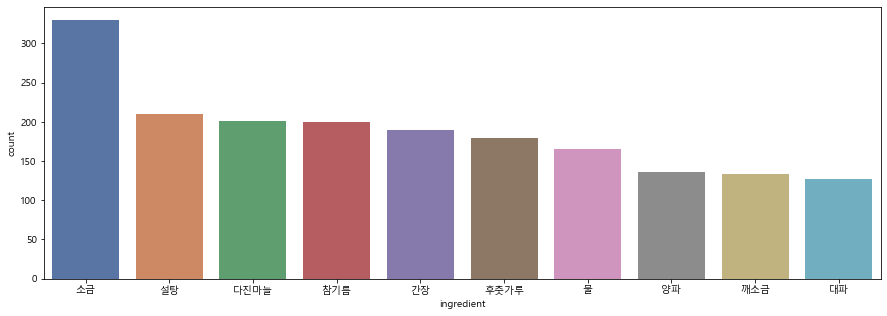

In [44]:
plt.rc('font', family='Malgun Gothic')
#Plot top ingredients using bag of words
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(x = 'ingredient', y = 'count', data = top_ing.head(10))
sns.set_palette("deep")
plt.show()

In [61]:
#Get all clean ingredients in list format per recipe
ingr_list = []
for IRDNT_NM in df_tmp_arr:
    ingr_list.append(IRDNT_NM)

In [62]:
def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df

In [63]:
#PMI Calculation starts
#Point-wise mutual information to understand which ingredients go together and which ones don't

#Create combinations of ingredients
start_time = time.time()

l = []
for K in range(len(ingr_list)):
    for L in range(2,3):
        for subset in itertools.combinations(ingr_list[K], L):
            l.append(sorted(subset))       
#print("--- %s seconds ---" % (time.time() - start_time))

In [64]:
#Function - Point-wise mutual information
def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df

In [65]:
#Convert list of tuples to dataframe
df = pd.DataFrame(l, columns = ['Ingredient1','Ingredient2'])

#Eliminate rows where Ingredient1 = Ingredient2
df = df[df['Ingredient1'] != df['Ingredient2']]

In [66]:
#Calculate PMI
df = pmi(df, 'Ingredient1', 'Ingredient2')

In [67]:
#Eliminate rows for the same ingredient combinations
df = df.drop_duplicates()

#Sort df
df = df.sort_values('pmi')

In [68]:
top_df = df.groupby('Ingredient1').head(5)
top_df.to_csv('pmi_ingredient_similarity_top.csv')

df = df.sort_values('pmi',ascending=True)
neg_df = df.groupby('Ingredient1').head(5)
neg_df.to_csv('pmi_ingredient_similarity_neg.csv')

In [69]:
temp = df[(df['Ingredient1'] == '소금') | (df['Ingredient2'] == '소금') ]

In [70]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [71]:
##Get clean ingredients to be used as an input for word2vec model to identify ingredient similarity.

ingr_clean_df = pd.DataFrame({'Ingredient':ingr_list})

In [72]:
#pip install -U gensim
#Implementing word2vec to get the recipes which are similar to each other

num_features = 300   # Word vector dimensionality                      
context = 1        # Context window size; 
downsampling = 1e-3   # threshold for configuring which higher-frequency words are randomly downsampled

# Initialize and train the model 
model = word2vec.Word2Vec(ingr_list, vector_size=num_features, window = context, sample = downsampling)

In [73]:
flatten_list = []
for sublist in ingr_list:
    for item in sublist:
        if item not in flatten_list:
            flatten_list.append(item)

In [74]:
most_sim_list = []
corpus_sim_dict = {}
input_list = []
for i in flatten_list:
    try: 
        if len(i) > 0:
            #print i
            corpus_sim_dict.update({i:model.wv.most_similar(i)})
    except KeyError:
        pass

In [75]:
sim_df = pd.DataFrame([])
for key,value in corpus_sim_dict.items():
    s = pd.DataFrame({'Ingredient': key, 'Similar Ingredient':i[0], 'Word2Vec Value': i[1] }, index=[0])
    for i in value:
        sim_df = pd.concat([s, sim_df], ignore_index=True)

In [76]:
from gensim.models.word2vec import Word2Vec
word2vecTSNE = Word2Vec(
    sg=1,
    vector_size=num_features, window = context, sample = downsampling,
    min_count=3
)
word2vecTSNE.build_vocab(ingr_list)

In [77]:
word2vecTSNE.train(ingr_list, total_examples= word2vecTSNE.corpus_count, epochs=word2vecTSNE.epochs)

(13023, 29265)

In [78]:
import os
if not os.path.exists("trained"):
    os.makedirs("trained")
word2vecTSNE.save(os.path.join("trained", "word2vecTSNE.w2v"))
word2vecTSNE = word2vec.Word2Vec.load(os.path.join("trained", "word2vecTSNE.w2v"))

In [79]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [80]:
all_word_vectors_matrix = word2vecTSNE.wv.vectors
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

C:\Users\LEE\PycharmProjects\Django_Jupyter\venv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\LEE\PycharmProjects\Django_Jupyter\venv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [81]:
#Plot the big picture

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[word2vecTSNE.wv.key_to_index[word]])
            for word in word2vecTSNE.wv.key_to_index
        ]
    ],
    columns=["word", "x", "y"]
)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
C:\Users\LEE\PycharmProjects\Django_Jupyter\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


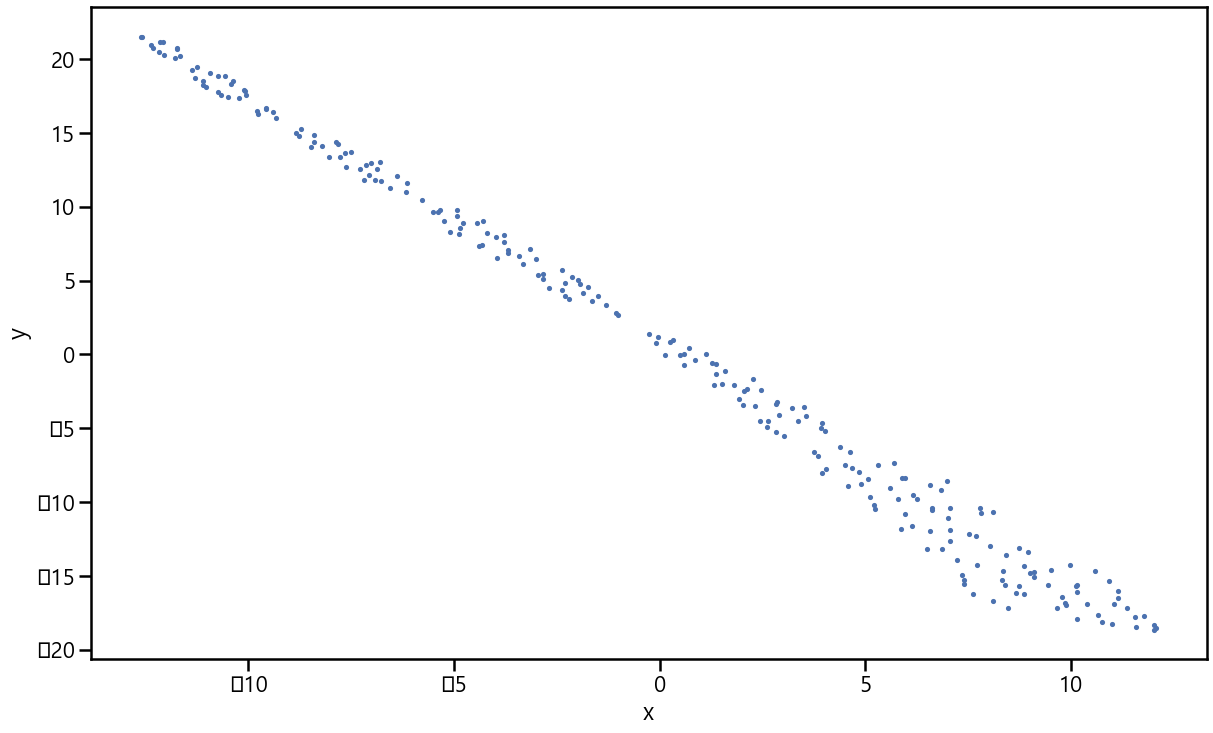

In [82]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))
plt.show()

In [83]:
#Zoom in to some interesting places


def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    ax = slice.plot.scatter("x", "y", s=35, figsize=(100, 80))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [84]:
points.head(10)
points.to_csv('word2vec_tse.csv')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


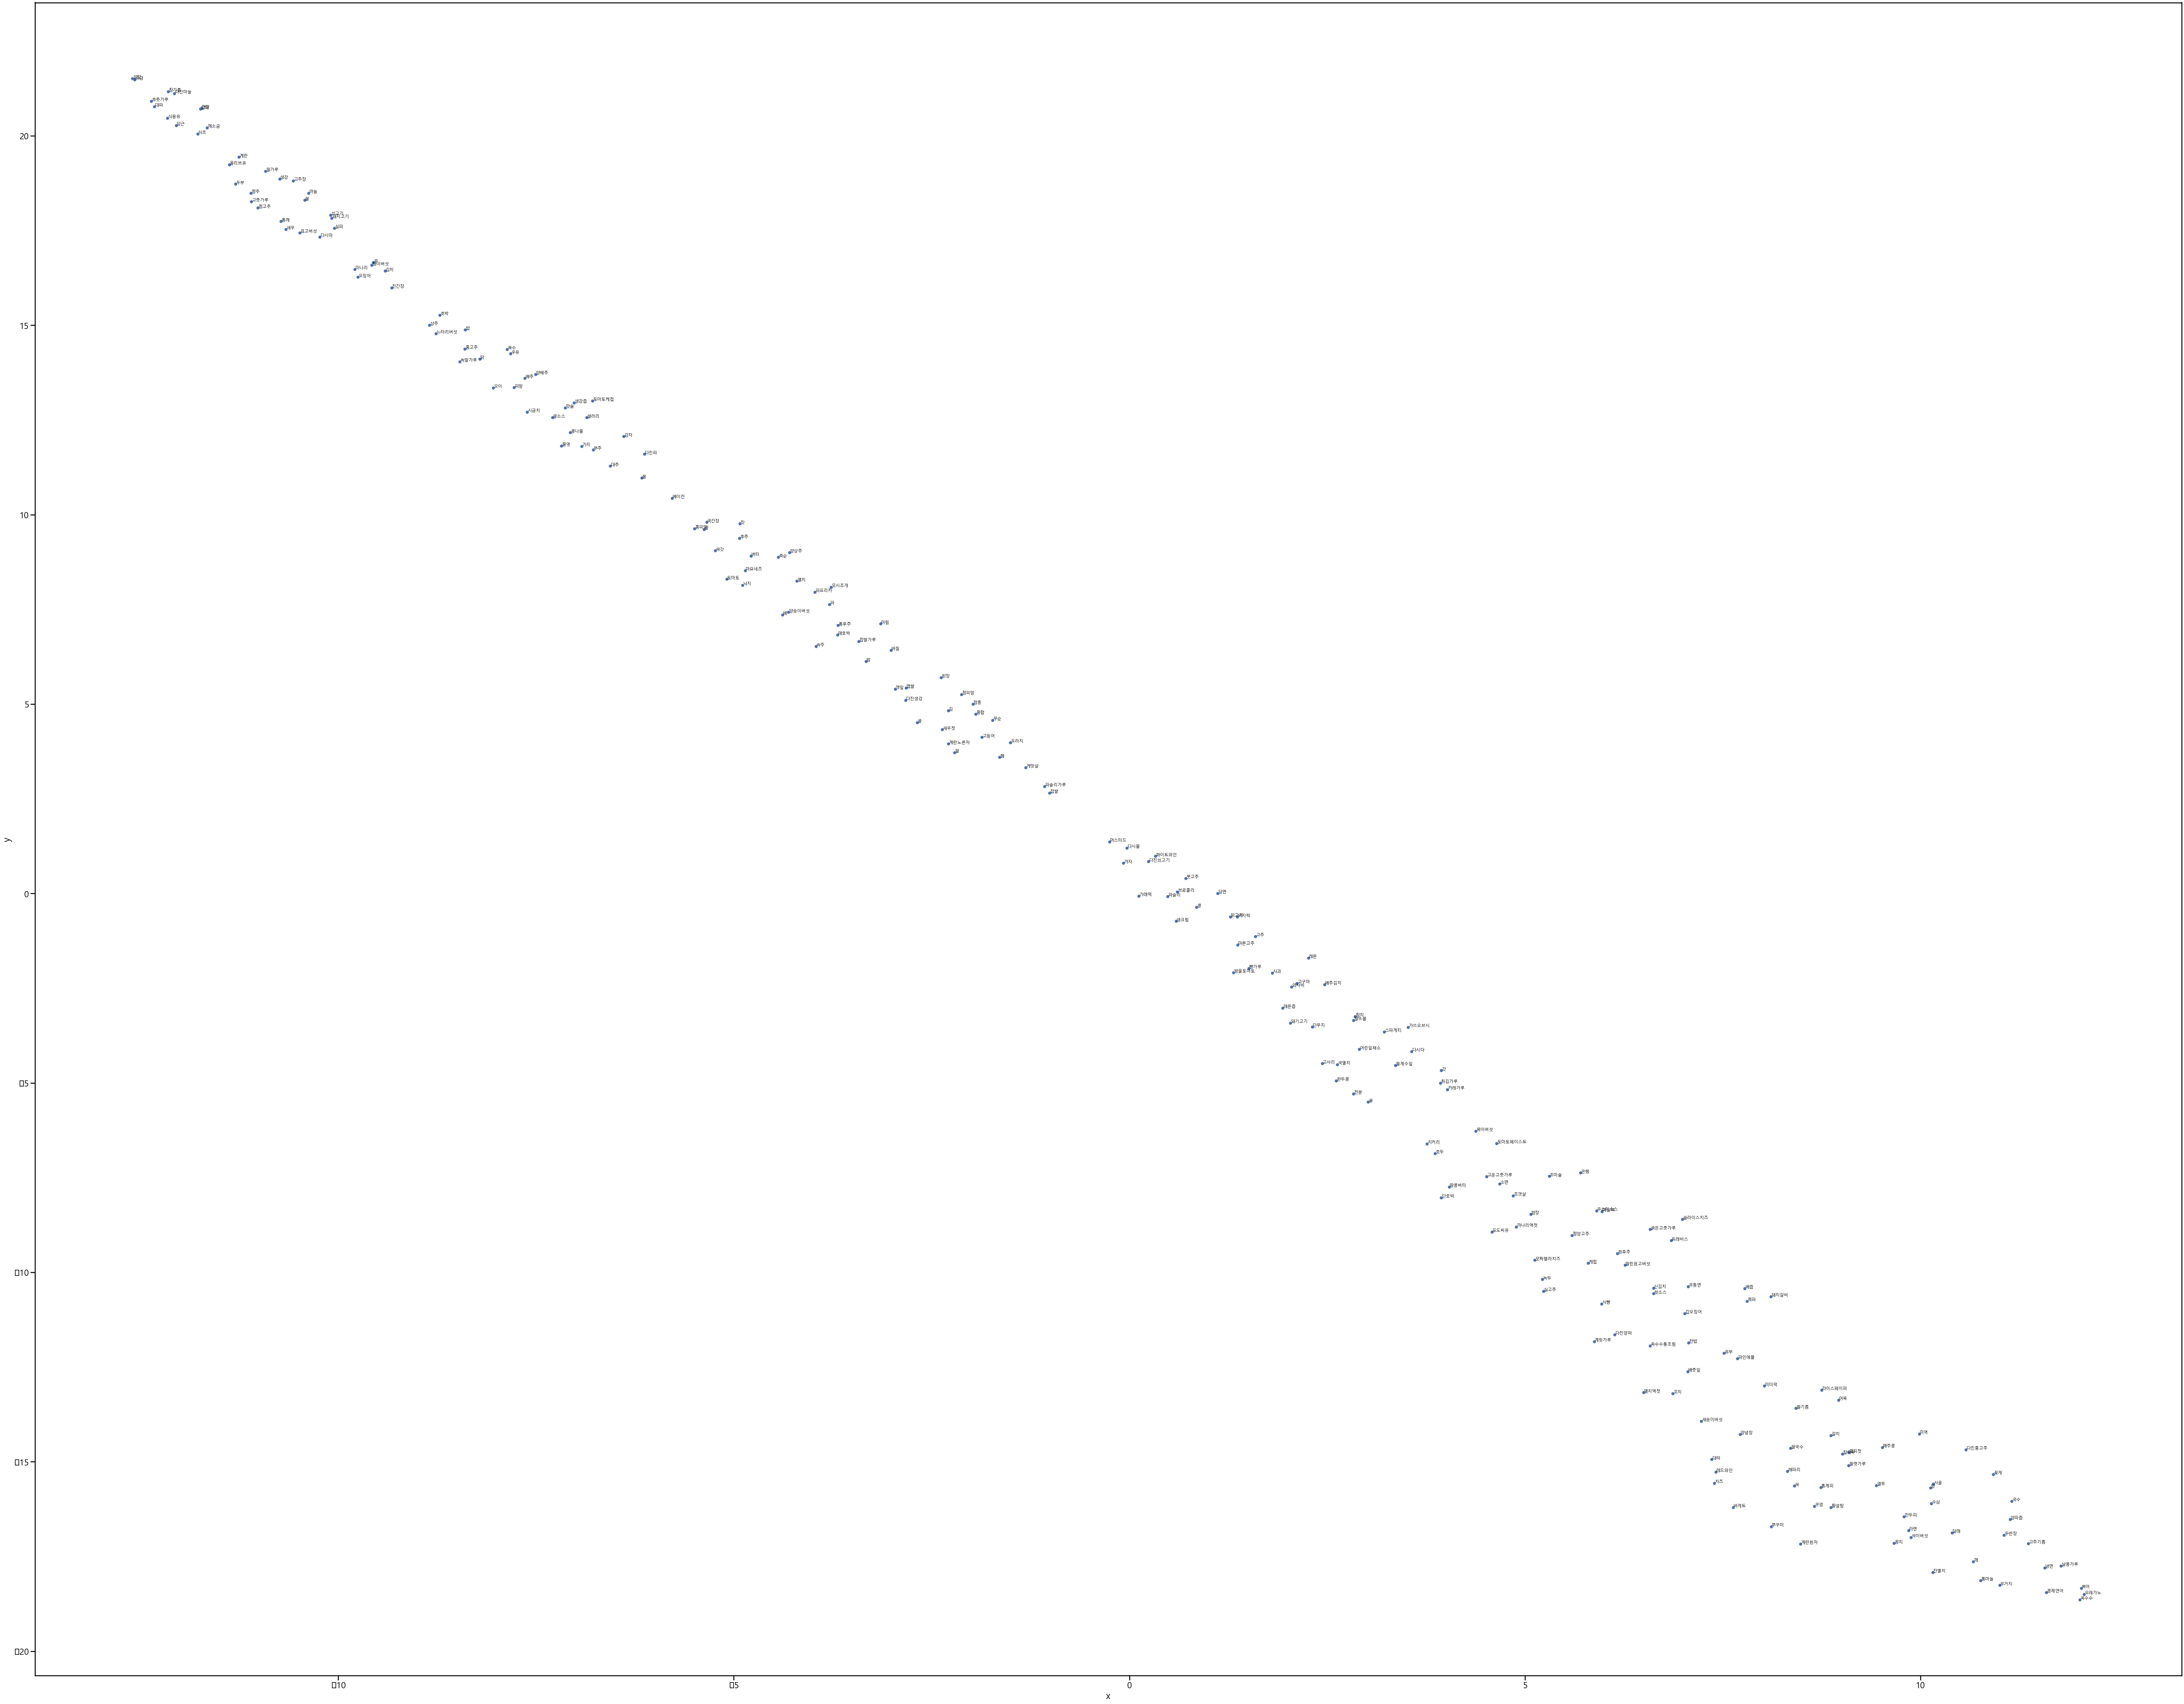

In [85]:
plot_region(x_bounds=(-40,40), y_bounds=(-40, 40))

In [86]:
sns.set_context("poster")
plt.show()

In [87]:
df = pd.read_csv('result/word2vec_ingredient_similarity.csv')
df = df.sort_values('Word2Vec Value',ascending=False)
top_df = df.groupby('Ingredient').head(5)
top_df.to_csv('result/word2vec_ingredient_similarity_top.csv')

In [88]:
#Create a dictionary for all the ingredients in the recipe list

dictionary = corpora.Dictionary(ingr_list)

In [89]:
#Applying doc2bow on the dictionary of ingredients, which converts the ingredient to a number in every recipe
#This input format is needed for TfIdfmodel
bow_corpus = [dictionary.doc2bow(text) for text in ingr_list]

In [90]:
# train the model
tfidf = models.TfidfModel(bow_corpus)

In [91]:
corpus_tfidf = tfidf[bow_corpus]

In [92]:
#Use similarities library from gensim to get the cosine similarity of the tfidf results

index = similarities.MatrixSimilarity(tfidf[bow_corpus])
index.save('ingr.index')
index = similarities.MatrixSimilarity.load('ingr.index')

sims = index[corpus_tfidf]
sims_list = [(i,j) for i,j in enumerate(sims)]

#Creating a list to hold the cosine similarity results for tfidf
tf_idf_list = []

for i,j in enumerate(sims_list):
    tf_idf_list.append(sims_list[i][1])

In [93]:
#Create recipe dict- to be used in creating dataframe in next step - used to decode recipe id
recipe_dict = {k: v for k, v in enumerate(df_basic.RECIPE_NM_KO)}

In [94]:
#Use cosine similarity results to get the top 10 similar recipes for every recipe.
tf_idf_top  = []
similar_recipes_df = pd.DataFrame([])
same_item = []

#Get only top 11 largest values from the tf_idf_list - 1 recipe will be the same as itself (hence 12)
for i,item in enumerate(tf_idf_list):
    tf_idf_top.append(heapq.nlargest(11,enumerate(item), key=lambda x: x[1]))

#Remove the recipe value with 1.0 similarity - since it is the same recipe
for i,list_item in enumerate(tf_idf_top):
    for j,k in enumerate(list_item):
        if tf_idf_top[i][j][1] != 1.0:
            d = pd.DataFrame({'Similar_Recipe_ID': recipe_dict.get(tf_idf_top[i][j][0]),'TF-IDF Value': tf_idf_top[i][j][1],'Recipe_ID': recipe_dict.get(i)}, index=[0])
            similar_recipes_df = pd.concat([d, similar_recipes_df], ignore_index=True)

In [95]:
similar_recipes_df = pd.read_csv('similar_recipes_top_10_tf_idf.csv')
similar_recipes_df = similar_recipes_df[similar_recipes_df['Recipe_ID'] != similar_recipes_df['Similar_Recipe_ID']]

In [96]:
names = [i for i in range(1,len(tf_idf_list))]
final_df = pd.DataFrame.from_dict(zip(names,tf_idf_list))

In [97]:
df_basic['RECIPE_ID'] = df_basic.index+1
recipe_name_df = df_basic[['RECIPE_ID','RECIPE_NM_KO']]
final_df['RECIPE_ID'] = final_df.index+1

recipe_tf_idf_df = final_df.merge(recipe_name_df,how='left', left_on='RECIPE_ID', right_on='RECIPE_ID')

In [98]:
#Create a list from tfidf results
#This will be used to identify ingredient importance within every recipe

corpus_list = []
for doc in corpus_tfidf:
    corpus_list.append(doc)

In [99]:
#Create a flat list to eliminate repetition of ingredients and create a dict to hold the results

flat_list = []
for sublist in ingr_list:
    for item in sublist:
        if item not in flat_list:
            flat_list.append(item)
ing_dict =  {k: v for k, v in enumerate(flat_list)}

In [100]:
#Create a dataframe with tf-idf values per ingredient for every recipe.
corpus_df = pd.DataFrame([])

for i,list_item in enumerate(corpus_list):
    for j,k in enumerate(list_item):
        f = pd.DataFrame({'Ingredient': dictionary.get(corpus_list[i][j][0]),'TF-IDF Value': corpus_list[i][j][1],'Recipe_ID': i}, index=[0])
        corpus_df = pd.concat([f, corpus_df], ignore_index=True)

In [101]:
df_basic['RECIPE_ID'] = df_basic.index
recipe_tf_idf_df = corpus_df.merge(df_basic,how='left', left_on='Recipe_ID', right_on='RECIPE_ID')
recipe_tf_idf_df = recipe_tf_idf_df[['Recipe_ID','RECIPE_NM_KO','Ingredient','TF-IDF Value']]

In [102]:
similar_recipes_df

,Unnamed: 0,Similar_Recipe_ID,TF-IDF Value,Recipe_ID
0,0,닭가슴살 호박말이,0.142468,콩비지동그랑땡
1,1,낙지볶음,0.142591,콩비지동그랑땡
2,2,배추겉절이,0.143484,콩비지동그랑땡
3,3,갈비탕,0.164151,콩비지동그랑땡
4,4,꽃만두국(완당국),0.168596,콩비지동그랑땡
...,...,...,...,...
5467,5467,숙주미나리무침,0.281138,나물비빔밥
5468,5468,돌솥비빔밥,0.284462,나물비빔밥
5469,5469,콩나물미나리무침,0.292764,나물비빔밥
5470,5470,상추겉절이비빔밥,0.316848,나물비빔밥
